In [1]:
# add path to sispeuede to sys.path in python
import sys
dir_git = "/Users/usuario/git/sisepuede"
if dir_git not in sys.path:
    sys.path.append(dir_git)

import warnings
warnings.filterwarnings("ignore")
    
#estimate_ft_probs_by_luc_type

#import sisepuede.transformers.afolu as dta
#import sisepuede.transformers.circular_economy as dtc
#import sisepuede.transformers.energy as dte
#import sisepuede.transformers.ippu as dti
#import sisepuede.transformers.integrated as dtr

import os, os.path
import numpy as np
import pandas as pd

#from sisepuede.core.model_attributes import *
import sisepuede.core.model_attributes as ma
import sisepuede.models.afolu as mafl
import sisepuede.models.ippu as mi
import sisepuede.models.circular_economy as mc
import sisepuede.models.energy_production as ml
import sisepuede.models.energy_consumption as me
import sisepuede.models.socioeconomic as se
import sisepuede.core.model_variable as mv

#import sisepuede.legacy.setup_analysis as sa
#import sisepuede.legacy.data_api as api
import sisepuede.manager.sisepuede_models as sm
import sisepuede.core.support_classes as sc
import sisepuede.utilities._toolbox as sf
import importlib
import pathlib
import time
import warnings
import matplotlib.pyplot as plt
from typing import *
import inspect
import sisepuede.data_management.ingestion as ing
import logging
from sisepuede.manager.sisepuede_file_structure import *
import sisepuede.transformers.lib._baselib_afolu as tba
import sisepuede.transformers.lib._baselib_circular_economy as tbc
import sisepuede.transformers.lib._baselib_energy as tbe
import sisepuede.transformers.lib._baselib_general as tbg
import sisepuede.transformers.lib._baselib_ippu as tbi


importlib.reload(ma)
importlib.reload(sf)
importlib.reload(mafl)
importlib.reload(mc)
importlib.reload(mi)
importlib.reload(me)
importlib.reload(se)
importlib.reload(tbc)
importlib.reload(tbe)



#
# add data pipeline to path
#
fp_pipeline = "/Users/usuario/git/sisepuede_data_pipeline/"
if fp_pipeline not in sys.path:
    sys.path.append(fp_pipeline)
fp_pipeline = pathlib.Path(fp_pipeline)



import sisepuede.geo.geo_functions as gf

import lib.process_utilities as pu
import lib._geo as geolib
import lib._geo_classes as gcl
import afolu.geo.lib._get_gridded_dataset as gridded




In [2]:
from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure

In [3]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
from typing import Union
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")


In [4]:
%load_ext autoreload
%autoreload 2

### Initial Set up

Make sure to edit the config yaml under croatia/config_files/croatia_config.yaml

You can also create a new config yaml



In [5]:
# Set up dir paths

dir_cur = pathlib.Path(os.getcwd())
dir_ssp_modeling = dir_cur.parent
dir_project = dir_ssp_modeling.parent
dir_data = dir_ssp_modeling.joinpath("input_data")
dir_scenario_mapping = dir_ssp_modeling.joinpath("scenario_mapping")
dir_config = dir_ssp_modeling.joinpath("config_files")
dir_transformations = dir_ssp_modeling.joinpath("transformations")
dir_misc = dir_ssp_modeling.joinpath("misc")
strategies_definitions_file_path = dir_transformations.joinpath("strategy_definitions.csv")
strategy_mapping_file_path = dir_misc.joinpath("strategy_mapping.yaml")

In [6]:
dir_scenario_mapping

PosixPath('/Users/usuario/git/ssp_uganda/ssp_modeling/scenario_mapping')

In [ ]:
from ssp_transformations_handler.GeneralUtils import GeneralUtils
from ssp_transformations_handler.TransformationUtils import TransformationYamlProcessor, StrategyCSVHandler

# Initialize general utilities
g_utils = GeneralUtils()

In [7]:
# Load config file, double check your parameters are correct

yaml_file_path = os.path.join(dir_config, "bau_config.yaml")


country_name = "uganda"
ssp_input_file_name = "ssp_inputs_uganda_BaU_Scenario.csv"
ssp_transformation_cw = "ssp_uganda_transformation_cw_2025_03_11.xlsx"
set_lndu_reallocation_factor_to_zero = True
set_lndu_reallocation_factor_to_zero_flag = True
energy_model_flag = False

# country_name = config_params['country_name']
# ssp_input_file_name = config_params['ssp_input_file_name']
# ssp_transformation_cw = config_params['ssp_transformation_cw']
# energy_model_flag = config_params['energy_model_flag']
# set_lndu_reallocation_factor_to_zero_flag = config_params['set_lndu_reallocation_factor_to_zero']

# Print config parameters
print("Country name: ", country_name)
print("SSP input file name: ", ssp_input_file_name)
print("SSP transformation CW: ", ssp_transformation_cw)
print("Energy model flag: ", energy_model_flag)
print("Set lndu reallocation factor to zero flag: ", set_lndu_reallocation_factor_to_zero_flag)

Country name:  uganda
SSP input file name:  ssp_inputs_uganda_BaU_Scenario.csv
SSP transformation CW:  ssp_uganda_transformation_cw_2025_03_11.xlsx
Energy model flag:  False
Set lndu reallocation factor to zero flag:  True


In [8]:
# Set up SSP objects

fp_data_base = dir_data.joinpath(ssp_input_file_name)

file_struct = SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

### Making sure our input file has the correct format and correct columns
We use an example df with the complete fields and correct format to make sure our file is in the right shape

In [156]:
##  BUILD BASE INPUTS
df_inputs_raw = pd.read_csv(fp_data_base)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

In [ ]:
# Check frac variables in df_inputs_raw
g_utils.check_frac_groups(df_inputs_raw, os.path.join(dir_misc, "energy_frac_vars.xlsx"))

In [ ]:
g_utils.check_individual_frac_vars(df_inputs_raw)

In [ ]:
# Checks if there are any differences in columns between the example df and our df
g_utils.compare_dfs(df_inputs_example, df_inputs_raw)


In [ ]:
# Check for duplicated col names
duplicated_columns = df_inputs_raw.columns[df_inputs_raw.columns.duplicated()].tolist()
print(duplicated_columns)

In [440]:
# Fixes differences and makes sure that our df is in the correct format.
# Note: Edit this if you need more changes in your df

df_inputs_raw = (
    regions.convert_region_codes(
        df_inputs_raw,
        "iso_code3",
        "iso",
        "region"
    )
    .rename(
        columns = {
            "period": time_periods.field_time_period, 
            "Year": time_periods.field_year,
        }
    )
)

df_inputs_raw_complete = [x for x in df_inputs_example.columns if x not in df_inputs_raw.columns and x in matt.all_variable_fields]
df_inputs_raw_complete = pd.concat(
    [
        df_inputs_raw,
        df_inputs_example[df_inputs_raw_complete]
    ],
    axis = 1,
) 

if set_lndu_reallocation_factor_to_zero_flag:
    modvar_lurf = matt.get_variable("Land Use Yield Reallocation Factor")
    df_inputs_raw_complete[modvar_lurf.fields] = 0
#g_utils.add_missing_cols(df_inputs_example, df_inputs_raw.copy())
# df_inputs_raw_complete = g_utils.remove_additional_cols(df_inputs_example, df_inputs_raw.copy())
#df_inputs_raw_complete = df_inputs_raw_complete.drop(columns='iso_code3', errors='ignore')


In [ ]:
# Double checking that our df is in the correct shape (Empty sets should be printed to make sure everything is Ok!)
#g_utils.compare_dfs(df_inputs_example, df_inputs_raw_complete)

In [ ]:
df_inputs_raw_complete[[col for col in df_inputs_raw_complete.columns if 'pop_lvst_initial_cattle_dairy' in col]].head()

In [ ]:
df_inputs_raw_complete = df_inputs_raw_complete.drop(columns='pop_lvst_initial_cattle_dairy.1')
df_inputs_raw_complete[[col for col in df_inputs_raw_complete.columns if 'pop_lvst_initial_cattle_dairy' in col]].head()

In [ ]:
# Checking region to avoid copy errors
df_inputs_raw_complete['region'].head()

In [ ]:
# Set region to country name
df_inputs_raw_complete['region'] = country_name
df_inputs_raw_complete['region'].head()

# frac_lndu_initial modification

In [145]:
df_inputs_raw_complete[[i for i in df_inputs_raw_complete.columns if "frac_lndu_initial_" in i]].iloc[0]


frac_lndu_initial_forests_mangroves    0.000000
frac_lndu_initial_wetlands             0.191637
frac_lndu_initial_forests_primary      0.088106
frac_lndu_initial_settlements          0.002294
frac_lndu_initial_forests_secondary    0.017221
frac_lndu_initial_other                0.019260
frac_lndu_initial_grasslands           0.219108
frac_lndu_initial_croplands            0.462375
Name: 0, dtype: float64

In [146]:
frac_lndu = pd.read_excel(os.path.join(dir_scenario_mapping, 'Final scenario LULC areas_shared with SISEPUEDE.xlsx'), sheet_name='frac_lndu')
frac_lndu

,frac_lndu_initial_croplands,frac_lndu_initial_forests_mangroves,frac_lndu_initial_forests_primary,frac_lndu_initial_forests_secondary,frac_lndu_initial_grasslands,frac_lndu_initial_other,frac_lndu_initial_settlements,frac_lndu_initial_wetlands
0,0.525639,0,0.025318,0.129856,0.266578,0.000548,0.009043,0.043018


In [442]:
df_inputs_raw_complete["frac_lndu_initial_forests_primary"] = frac_lndu["frac_lndu_initial_forests_primary"] 
df_inputs_raw_complete["frac_lndu_initial_forests_secondary"] = frac_lndu["frac_lndu_initial_forests_secondary"]
df_inputs_raw_complete['frac_lndu_initial_forests_mangroves'] = frac_lndu['frac_lndu_initial_forests_mangroves']
df_inputs_raw_complete['frac_lndu_initial_grasslands'] = frac_lndu['frac_lndu_initial_grasslands']
df_inputs_raw_complete['frac_lndu_initial_settlements'] = frac_lndu['frac_lndu_initial_settlements'] 
df_inputs_raw_complete['frac_lndu_initial_wetlands'] = frac_lndu['frac_lndu_initial_wetlands']
df_inputs_raw_complete['frac_lndu_initial_croplands'] = frac_lndu['frac_lndu_initial_croplands']
df_inputs_raw_complete['frac_lndu_initial_other'] = frac_lndu['frac_lndu_initial_other']

In [160]:
df_inputs_raw_complete[[i for i in df_inputs_raw_complete.columns if "frac_lndu_initial_" in i]].iloc[0]

frac_lndu_initial_forests_mangroves    0.000000
frac_lndu_initial_wetlands             0.043018
frac_lndu_initial_forests_primary      0.025318
frac_lndu_initial_settlements          0.009043
frac_lndu_initial_forests_secondary    0.129856
frac_lndu_initial_other                0.000548
frac_lndu_initial_grasslands           0.266578
frac_lndu_initial_croplands            0.525639
Name: 0, dtype: float64

# Trancision Matrix

In [443]:
pij_ex = df_inputs_example[[i for i in df_inputs_example.columns if "pij_" in i]].columns
pij_ex

Index(['pij_lndu_croplands_to_croplands',
       'pij_lndu_croplands_to_forests_mangroves',
       'pij_lndu_croplands_to_forests_primary',
       'pij_lndu_croplands_to_forests_secondary',
       'pij_lndu_croplands_to_grasslands', 'pij_lndu_croplands_to_other',
       'pij_lndu_croplands_to_settlements', 'pij_lndu_croplands_to_wetlands',
       'pij_lndu_forests_mangroves_to_croplands',
       'pij_lndu_forests_mangroves_to_forests_mangroves',
       'pij_lndu_forests_mangroves_to_forests_primary',
       'pij_lndu_forests_mangroves_to_forests_secondary',
       'pij_lndu_forests_mangroves_to_grasslands',
       'pij_lndu_forests_mangroves_to_other',
       'pij_lndu_forests_mangroves_to_settlements',
       'pij_lndu_forests_mangroves_to_wetlands',
       'pij_lndu_forests_primary_to_croplands',
       'pij_lndu_forests_primary_to_forests_mangroves',
       'pij_lndu_forests_primary_to_forests_primary',
       'pij_lndu_forests_primary_to_forests_secondary',
       'pij_lndu_forests

##  First, look at current transition matrices

<Axes: >

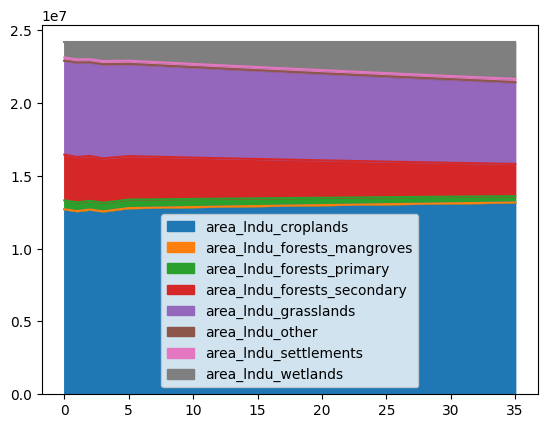

In [444]:
df_out = model_afolu(df_inputs_raw_complete)
(
    matt.extract_model_variable(
        df_out,
        model_afolu.modvar_lndu_area_by_cat,
    )
    .plot
    .area()
)





##  Get baseline targets from Diji

- Final plot shows what target land use will look like

<Axes: xlabel='year'>

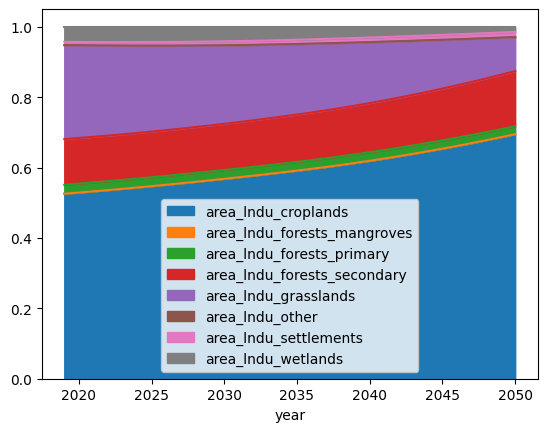

In [456]:
modvar_area = matt.get_variable(model_afolu.modvar_lndu_area_by_cat)
modvar_frac = matt.get_variable(model_afolu.modvar_lndu_initial_frac)
modvar_probs = matt.get_variable(model_afolu.modvar_lndu_prob_transition)

df_lulc_areas = pd.read_excel(
    os.path.join(dir_scenario_mapping, 'Final scenario LULC areas_shared with SISEPUEDE.xlsx'), 
    skiprows = 3,
    sheet_name = "Data for Diji", 
)


dict_rnm = {
    "field_sisepuede": "variable_field",
    "Baseline 2019 proportion of land area (%).1": 2019,
    "BAU 2030 LULC proportion of land area (%).1": 2030,
    "BAU 2040 proportion of land area (%).1": 2040,
    "BAU 2050 proportion of land area (%).1": 2050,
}

df_lulc_areas = (
    df_lulc_areas[fields_ext]
    .iloc[0:8]
    .rename(columns = dict_rnm, )
    .set_index("variable_field")
    .transpose()
    .reset_index(drop = False, )
    .rename(columns = {"index": time_periods.field_year})
)


df_years = (
    time_periods
    .get_time_period_df(
        include_year = True, 
        years = np.arange(
            df_lulc_areas[time_periods.field_year].min(),
            df_lulc_areas[time_periods.field_year].max() + 1,
        )
    )
    .drop(columns = time_periods.field_time_period, )
)

# ensure that the fields are appropriately denoted and complete
df_lulc_areas = modvar_frac.get_from_dataframe(
    pd.merge(
        df_years,
        df_lulc_areas,
        how = "left",
    )
    .interpolate(method = "quadratic", ),
    fields_additional = [time_periods.field_year],
)

#df_lulc_areas["frac_lndu_initial_forests_mangroves"] = 0.000001

# renormalize to ensure summation to 1 after inerpolating (minor deviations)
arr = modvar_frac.get_from_dataframe(
    df_lulc_areas,
    return_type = "array"
)

df_lulc_areas[modvar_frac.fields] = sf.do_array_mult(
    arr,
    1/arr.sum(axis = 1)
)


# convert to area name
df_lulc_areas = df_lulc_areas.rename(
    columns = matt.build_modvar_correspondence_dictionary(
        modvar_frac,
        modvar_area,
    )
)

df_lulc_areas.plot.area(x = "year")


##  Use SISEPUEDEDataPipeline QCorrector

- Will attempt to reproduce trajectory, but can't perfectly do so

In [175]:
import lib.optimization_utilities as ou
import afolu.geo.modvar_land_use_transition_probabilities as mlp

In [457]:
importlib.reload
QCorrector = ou.QCorrector()
importlib.reload(mlp)
# initial transition probabilities
df_q0 = modvar_probs.get_from_dataframe(
    df_inputs_raw_complete,
    fields_additional = [time_periods.field_year],
)
    

df_q_adj = mlp.adjust_transitions_in_region(
    df_q0,
    df_lulc_areas,
    model_afolu,
    time_periods,
    QCorrector,
    inds_absorp = [6], # allow settlements to absorb
    infimum_diag = 0.985,
    preserve_zeros = True,
)

df_q_adj = pd.concat(
    [
        df_q0[
            df_q0[time_periods.field_year]
            .le(df_q_adj[time_periods.field_year].min() - 1)
        ],
        df_q_adj,
    ]
)

df_q_adj = (
    pd.merge(
        df_q0[[time_periods.field_year]],
        df_q_adj,
        how = "left",
    )
    .ffill()
)

df_inputs_raw_complete_adj = sf.match_df_to_target_df(
    df_inputs_raw_complete,
    df_q_adj,
    [time_periods.field_year],
)

<Axes: >

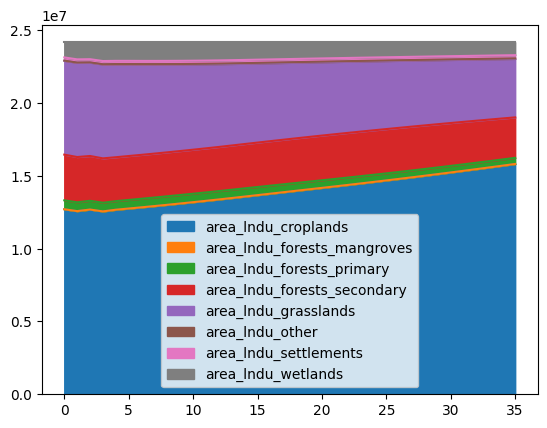

In [458]:
df_out2 = model_afolu(df_inputs_raw_complete_adj)
(
    matt.extract_model_variable(
        df_out2,
        model_afolu.modvar_lndu_area_by_cat,
    )
    .plot
    .area()
)





In [429]:
matt.extract_model_variable(
    df_q_adj,
    modvar_probs
).tail()

fields = [x for x in df_q_adj.columns if "forests_secondary_to" in x]
df_q_adj[fields].tail()


,pij_lndu_forests_secondary_to_croplands,pij_lndu_forests_secondary_to_forests_mangroves,pij_lndu_forests_secondary_to_forests_primary,pij_lndu_forests_secondary_to_forests_secondary,pij_lndu_forests_secondary_to_grasslands,pij_lndu_forests_secondary_to_other,pij_lndu_forests_secondary_to_settlements,pij_lndu_forests_secondary_to_wetlands
31,0.015136,0.0,0.000005,0.984848,0.000002,0.000005,0.0,0.000004
32,0.015350,0.0,0.000000,0.984650,0.000000,0.000000,0.0,0.000000
33,0.015524,0.0,0.000000,0.984476,0.000000,0.000000,0.0,0.000000
34,0.015682,0.0,0.000000,0.984318,0.000000,0.000000,0.0,0.000000
35,0.015682,0.0,0.000000,0.984318,0.000000,0.000000,0.0,0.000000


In [430]:
matt.extract_model_variable(
    df_inputs_raw_complete,
    modvar_probs
).tail()

df_inputs_raw_complete[fields].tail()

,pij_lndu_forests_secondary_to_croplands,pij_lndu_forests_secondary_to_forests_mangroves,pij_lndu_forests_secondary_to_forests_primary,pij_lndu_forests_secondary_to_forests_secondary,pij_lndu_forests_secondary_to_grasslands,pij_lndu_forests_secondary_to_other,pij_lndu_forests_secondary_to_settlements,pij_lndu_forests_secondary_to_wetlands
31,0.005996,0,0.000004,0.990017,0.003959,0.000011,0,0.000012
32,0.005996,0,0.000004,0.990017,0.003959,0.000011,0,0.000012
33,0.005996,0,0.000004,0.990017,0.003959,0.000011,0,0.000012
34,0.005996,0,0.000004,0.990017,0.003959,0.000011,0,0.000012
35,0.005996,0,0.000004,0.990017,0.003959,0.000011,0,0.000012


In [ ]:
df_inputs_raw_complete.to_csv(
    dir_data.joinpath("ssp_inputs_uganda_bau_scenario_with_dijis_inputs_and_adj_qmats.csv"),
    encoding = "UTF-8",
    index = None,
)

#  Let's try building transformations using this


In [128]:
# use adjusted set
transformers = trf.transformers.Transformers(
    {},
    df_input = df_inputs_raw_complete_adj,
)

##  Instantiate some transformations. Make sure to run this cell to create the transformations folder for the first time or if you wish to overwrite

In [129]:
# set an ouput path and instantiate
if not dir_transformations.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        dir_transformations,
    )
else:
    print(f"Directory {dir_transformations} already exists. Skipping instantiation.")


Directory /home/fabian_fuentes/repos/ssp_uganda/ssp_modeling/transformations already exists. Skipping instantiation.


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--

### Customizing transformations and strategies files using TransformationUtils.py classes

In [130]:
?TransformationYamlProcessor

Init signature:
TransformationYamlProcessor(
    scenario_mapping_excel_path,
    yaml_dir_path,
    sheet_name='yaml',
)
Docstring:     
TransformationYamlProcessor is a class designed to handle the processing of YAML files based on scenario mappings provided in an Excel file. It provides methods to load scenario mappings, retrieve strategy names, load YAML data, save modified YAML files, and process YAML files according to specified transformations.
Methods:
    __init__(self, scenario_mapping_excel_path, yaml_dir_path, sheet_name='yaml'):
        Initializes the TransformationYamlProcessor class with the given parameters.
    load_scenario_mapping_excel(self):
    load_yaml_data(self, yaml_file_path):
    get_strategy_names(self):
    save_yaml_file(self, yaml_content, yaml_name, column, transformation_code, subsector, transformation_name, scalar_val):
    get_transformations_per_strategy_dict(self):
    process_yaml_files(self):
Init docstring:
Initializes the TransformationUtils c

In [131]:
# Generate new transformation files based on the excel mapping file. 
# Make sure to have the most updated format for the excel file, check the one used in this notebook for reference.

cw_file_path = os.path.join(dir_scenario_mapping, ssp_transformation_cw)
print(cw_file_path)
excel_yaml_handler = TransformationYamlProcessor(scenario_mapping_excel_path=cw_file_path, yaml_dir_path=dir_transformations)

/home/fabian_fuentes/repos/ssp_uganda/ssp_modeling/scenario_mapping/ssp_uganda_transformation_cw_2025_04_21.xlsx


In [132]:
# This creates transformation yaml files for each strategy in the excel file
excel_yaml_handler.process_yaml_files()

YAML file transformation_agrc_inc_conservation_agriculture.yaml already exist for strategy strategy_NDC. Please check it manually.
YAML file transformation_agrc_inc_conservation_agriculture.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_inen_shift_fuel_heat.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_lsmm_inc_management_cattle_pigs.yaml already exist for strategy strategy_NDC. Please check it manually.
YAML file transformation_lsmm_inc_management_cattle_pigs.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_lsmm_inc_management_other.yaml already exist for strategy strategy_NDC. Please check it manually.
YAML file transformation_lsmm_inc_management_other.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_lsmm_inc_management_poultry.yaml already exist for strategy strategy_NDC. Please check it manua

In [133]:
# Load the transformations per strategy dictionary so we can pass it to the strategy handler
# You can also check here if the transformations in each strategy are correct
transformation_per_strategy_dict = excel_yaml_handler.get_transformations_per_strategy_dict()
transformation_per_strategy_dict

{'strategy_NDC': ['TX:AGRC:DEC_CH4_RICE_STRATEGY_NDC',
  'TX:AGRC:INC_CONSERVATION_AGRICULTURE_STRATEGY_NDC',
  'TX:AGRC:INC_PRODUCTIVITY_STRATEGY_NDC',
  'TX:ENTC:DEC_LOSSES_STRATEGY_NDC',
  'TX:ENTC:TARGET_CLEAN_HYDROGEN_STRATEGY_NDC',
  'TX:ENTC:TARGET_RENEWABLE_ELEC_STRATEGY_NDC',
  'TX:INEN:INC_EFFICIENCY_ENERGY_STRATEGY_NDC',
  'TX:INEN:INC_EFFICIENCY_PRODUCTION_STRATEGY_NDC',
  'TX:IPPU:DEC_CLINKER_STRATEGY_NDC',
  'TX:IPPU:DEC_DEMAND_STRATEGY_NDC',
  'TX:IPPU:DEC_HFCS_STRATEGY_NDC',
  'TX:LNDU:DEC_DEFORESTATION_STRATEGY_NDC',
  'TX:LNDU:INC_REFORESTATION_STRATEGY_NDC',
  'TX:LSMM:INC_CAPTURE_BIOGAS_STRATEGY_NDC',
  'TX:LSMM:INC_MANAGEMENT_CATTLE_PIGS_STRATEGY_NDC',
  'TX:LSMM:INC_MANAGEMENT_OTHER_STRATEGY_NDC',
  'TX:LSMM:INC_MANAGEMENT_POULTRY_STRATEGY_NDC',
  'TX:LVST:INC_PRODUCTIVITY_STRATEGY_NDC',
  'TX:SOIL:DEC_LIME_APPLIED_STRATEGY_NDC',
  'TX:SOIL:DEC_N_APPLIED_STRATEGY_NDC',
  'TX:TRDE:DEC_DEMAND_STRATEGY_NDC',
  'TX:TRNS:INC_EFFICIENCY_ELECTRIC_STRATEGY_NDC',
  'TX:TRN

In [134]:
transformation_per_strategy_dict.keys()

dict_keys(['strategy_NDC', 'strategy_NZ'])

### Creating new strategies
- You can create new strategies from scratch.
- You can also update existing ones.

In [135]:
# Creating new strategies by updating the strategy_definitions file.
# You can edit this to add yours, as many as you want.
csv_handler = StrategyCSVHandler(strategies_definitions_file_path, dir_transformations, strategy_mapping_file_path, transformation_per_strategy_dict)

#csv_handler.add_strategy(strategy_group='PFLO', description='NDC BaU', yaml_file_suffix='BaU')
csv_handler.add_strategy(strategy_group='PFLO', description='NDC', yaml_file_suffix='NDC')
csv_handler.add_strategy(strategy_group='PFLO', description='Net Zero', yaml_file_suffix='NZ')


INFO: Strategy code PFLO:NDC already exists in the strategy definitions. Strategy will be updated...
Updated row with strategy_code PFLO:NDC
INFO: Strategy code PFLO:NZ already exists in the strategy definitions. Strategy will be updated...
Updated row with strategy_code PFLO:NZ


In [136]:
# Set up the strategy codes you wish to run in ssp
strategies_to_run = [0, 6003, 6004]

# Manual modification YAML

## TX:LNDU:DEC_DEFORESTATION

In [137]:

import yaml

with open(os.path.join(dir_transformations, 'transformation_lndu_dec_deforestation_strategy_NZ.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude'] = 0.999999   


with open(os.path.join(dir_transformations, 'transformation_lndu_dec_deforestation_strategy_NZ.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False)

  

In [138]:

with open(os.path.join(dir_transformations, 'transformation_lndu_dec_deforestation_strategy_NDC.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude'] = 0.88888   


with open(os.path.join(dir_transformations, 'transformation_lndu_dec_deforestation_strategy_NDC.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False) 

## TX:AGRC:INC_CONSERVATION_AGRICULTURE

In [139]:
with open(os.path.join(dir_transformations, 'transformation_agrc_inc_conservation_agriculture_strategy_NZ.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude_burned'] = 0.8
data['parameters']['magnitude_removed'] = 0.8   


with open(os.path.join(dir_transformations, 'transformation_agrc_inc_conservation_agriculture_strategy_NZ.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False) 

In [140]:
with open(os.path.join(dir_transformations, 'transformation_agrc_inc_conservation_agriculture_strategy_NDC.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude_burned'] = 0.6
data['parameters']['magnitude_removed'] = 0.6   


with open(os.path.join(dir_transformations, 'transformation_agrc_inc_conservation_agriculture_strategy_NDC.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False) 

### We finished adding new transformation files and strategies so lets load them back

In [141]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    dir_transformations,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table

In [142]:
#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

Strategies defined at /home/fabian_fuentes/repos/ssp_uganda/ssp_modeling/transformations initialized in 4.21 seconds


In [143]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
66,6000,PFLO:INC_HEALTHIER_DIETS,Singleton - Default Value - PFLO: Change diets,NaN,TX:PFLO:INC_HEALTHIER_DIETS,0
67,6001,PFLO:INC_IND_CCS,Singleton - Default Value - PFLO: Industrial c...,NaN,TX:PFLO:INC_IND_CCS,0
68,6002,PFLO:ALL,All Actions,All actions (unique by transformer),TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_EXPORTS|TX:AG...,0
69,6003,PFLO:NDC,NDC,NDC,TX:AGRC:DEC_CH4_RICE_STRATEGY_NDC|TX:AGRC:INC_...,0


##  Build our templates
- let's use the default variable groupings for LHS

In [144]:
# Building excel templates, make sure to include the strategies ids in the strategies attribute as well as the baseline (0)
df_vargroups = examples("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    df_trajgroup = df_vargroups,
    include_simplex_group_as_trajgroup = True,
    strategies = strategies_to_run,
)

starting strat 6003 with input shape (36, 2259)
strat 6003 with output shape (36, 2259)
here = 6003
starting strat 6004 with input shape (36, 2259)
strat 6004 with output shape (36, 2259)
here = 6004


0

# Finally, load SISEPUEDE so that we can run it

In [145]:
import sisepuede as si
# timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    # id_str = f"sisepuede_run_2024-11-04T09:23:26.721580",
    initialize_as_dummy = not(energy_model_flag), # no connection to Julia is initialized if set to True
    regions = [country_name],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = True,
)

2025-04-24 20:31:15,020 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-04-24 20:31:15,020 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-04-24 20:31:15,024 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-04-24 20:31:15,024 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-04-24 20:31:15,025 - INFO - 	Setting export engine to 'csv'.
2025-04-24 20:31:15,025 - INFO - 	Setting export engine to 'csv'.
2025-04-24 20:31:15,029 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-04-24 20:31:15,029 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-04-24 20:31:15,030 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-04-24 20:31:15,030 - INFO - Successfully

In [146]:
not(energy_model_flag)

True

In [147]:
# This runs the model, make sure you edit key_stretegy with the strategy ids you want to execute include baseline (0)
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: strategies_to_run,
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
    include_electricity_in_energy = energy_model_flag
)

2025-04-24 20:31:47,141 - INFO - 
***	STARTING REGION uganda	***

2025-04-24 20:31:47,141 - INFO - 
***	STARTING REGION uganda	***

2025-04-24 20:31:52,064 - INFO - Trying run primary_id = 0 in region uganda
2025-04-24 20:31:52,064 - INFO - Trying run primary_id = 0 in region uganda
2025-04-24 20:31:52,066 - INFO - Running AFOLU model
2025-04-24 20:31:52,066 - INFO - Running AFOLU model
2025-04-24 20:31:52,312 - INFO - AFOLU model run successfully completed
2025-04-24 20:31:52,312 - INFO - AFOLU model run successfully completed
2025-04-24 20:31:52,314 - INFO - Running CircularEconomy model
2025-04-24 20:31:52,314 - INFO - Running CircularEconomy model
2025-04-24 20:31:52,395 - INFO - CircularEconomy model run successfully completed
2025-04-24 20:31:52,395 - INFO - CircularEconomy model run successfully completed
2025-04-24 20:31:52,397 - INFO - Running IPPU model
2025-04-24 20:31:52,397 - INFO - Running IPPU model
2025-04-24 20:31:52,534 - INFO - IPPU model run successfully completed
2

{'uganda': [0, 69069, 70070]}

In [148]:
# df_run = ssp.generate_scenario_database_from_primary_key(0)
# df_run = df_run.get("iran")
# df_run.to_csv("/Users/usuario/Desktop/iran_baselines_temp.csv", encoding = "UTF-8", index = None, )

In [149]:
# Read input and output files
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

# option to pass `df_out` back to data_modifications
- do this if the outputs are needed to rescale input demand values to match IEA data

In [150]:
# (
#     df_out
#     .to_csv(
#         dir_data.joinpath("sisepuede_outputs_iran_preiea.csv"),
#         index = None,
#         encoding = "UTF-8",
#     )
# )

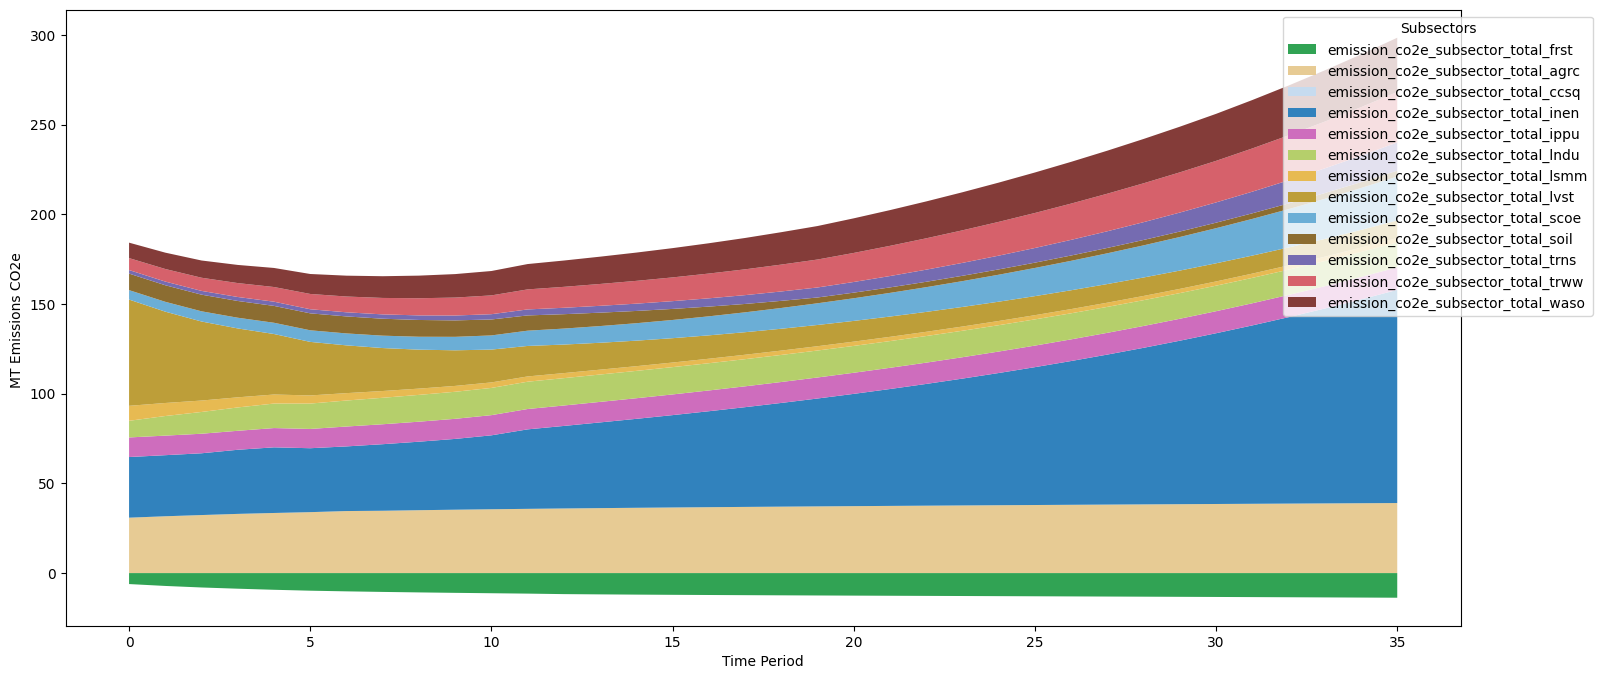

In [151]:

fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_out[
    df_out[ssp.key_primary].isin([0])
]


fields = matt.get_all_subsector_emission_total_fields()#[x for x in df_out.columns if (x.startswith("emission_co2e_subsector_total"))]
dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)

ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1), title="Subsectors")

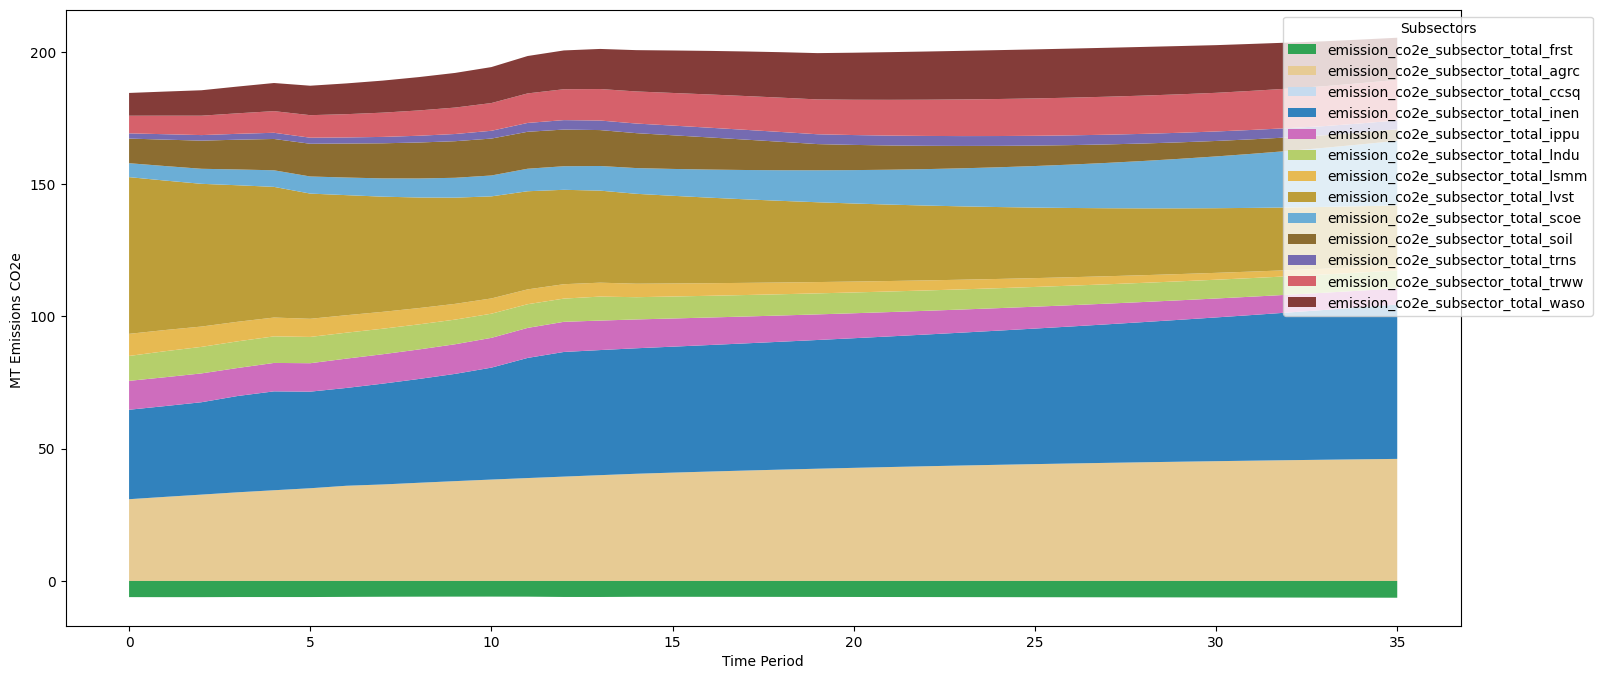

In [152]:
fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_out[
    df_out[ssp.key_primary].isin([69069])
]


fields = matt.get_all_subsector_emission_total_fields()#[x for x in df_out.columns if (x.startswith("emission_co2e_subsector_total"))]
dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)

ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1), title="Subsectors")

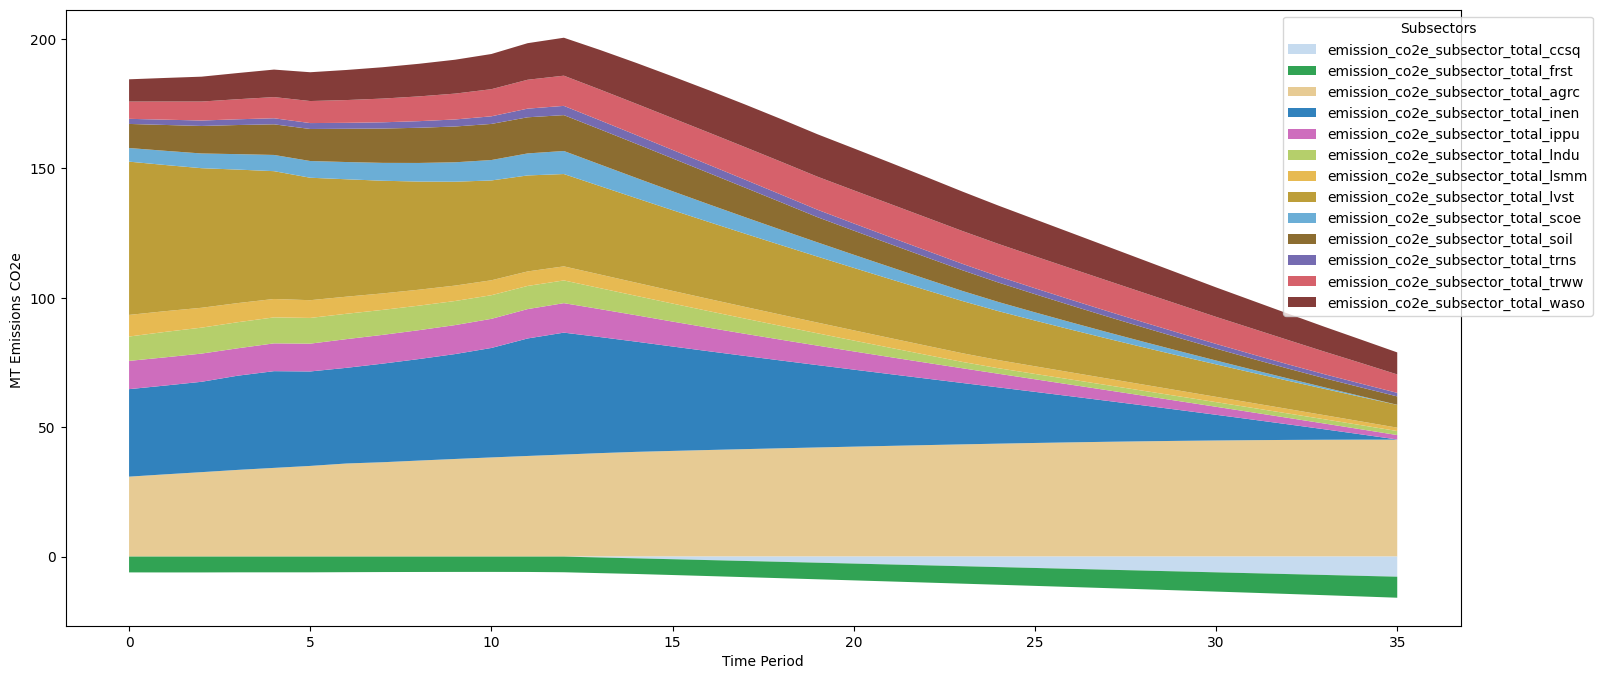

In [153]:
fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_out[
    df_out[ssp.key_primary].isin([70070])
]


fields = matt.get_all_subsector_emission_total_fields()#[x for x in df_out.columns if (x.startswith("emission_co2e_subsector_total"))]

dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1), title="Subsectors")

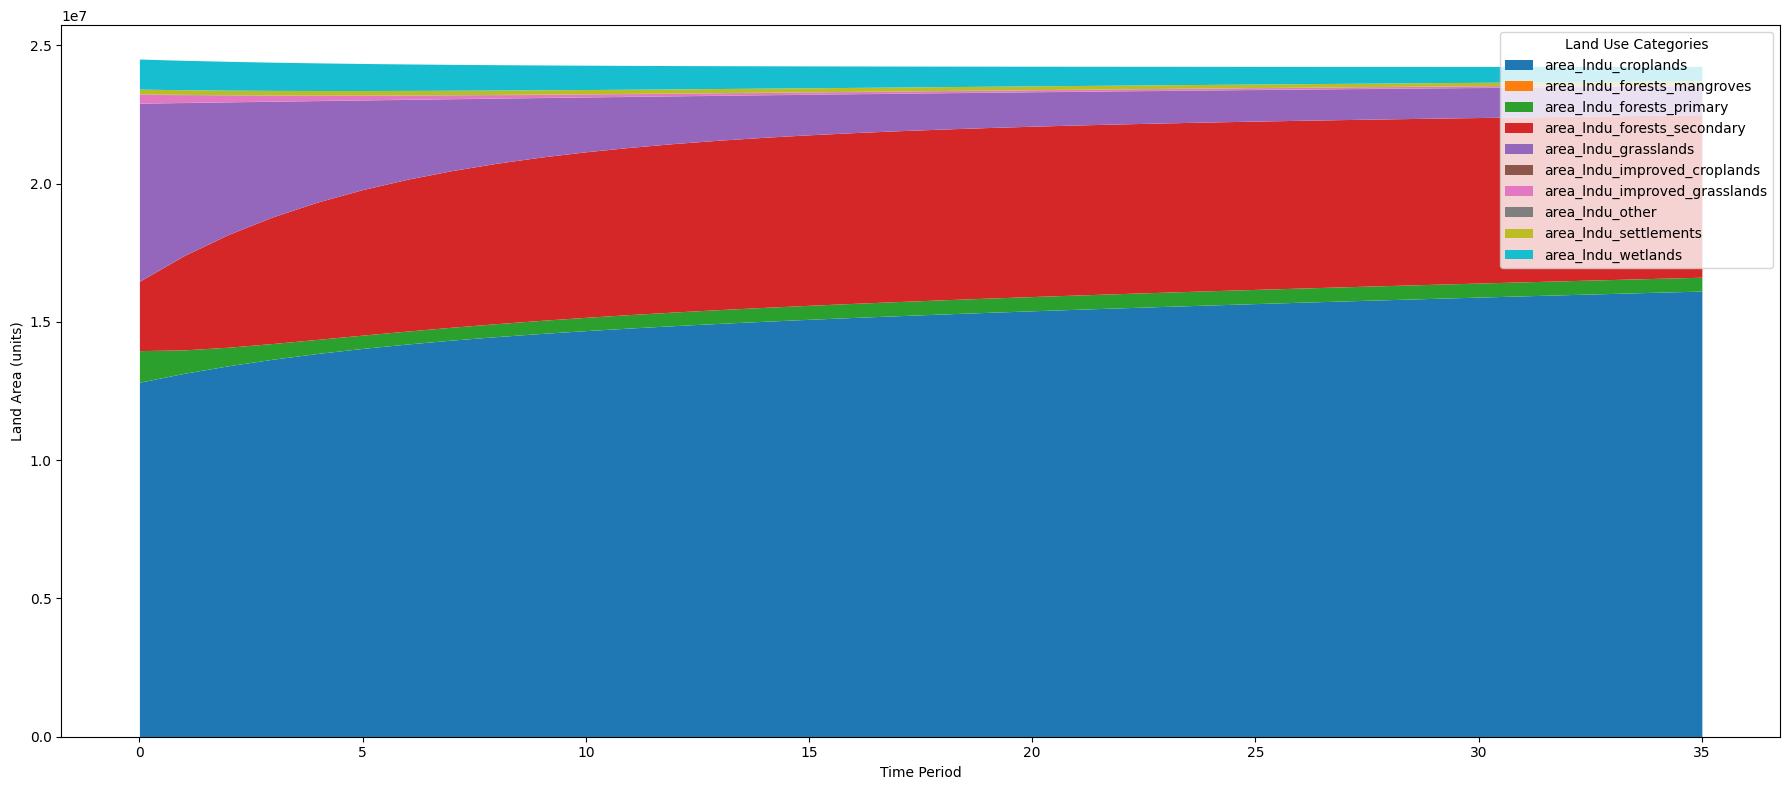

In [154]:
# Filtrar el dataframe
df_plot = df_out[df_out[ssp.key_primary] == 0]

# Lista de variables a graficar
areas = [
    'area_lndu_croplands',
    'area_lndu_forests_mangroves', 'area_lndu_forests_primary',
    'area_lndu_forests_secondary', 'area_lndu_grasslands',
    'area_lndu_improved_croplands', 'area_lndu_improved_grasslands',
    'area_lndu_other', 'area_lndu_settlements', 'area_lndu_wetlands'
]

# Crear el DataFrame para el área
df_area = df_plot.set_index("time_period")[areas]

# Graficar el área apilada
ax = df_area.plot.area(figsize=(18, 8), linewidth=0)

# Etiquetas y título
ax.set_xlabel("Time Period")
ax.set_ylabel("Land Area (units)")
ax.legend(loc='upper right', title="Land Use Categories")

plt.tight_layout()
plt.show()


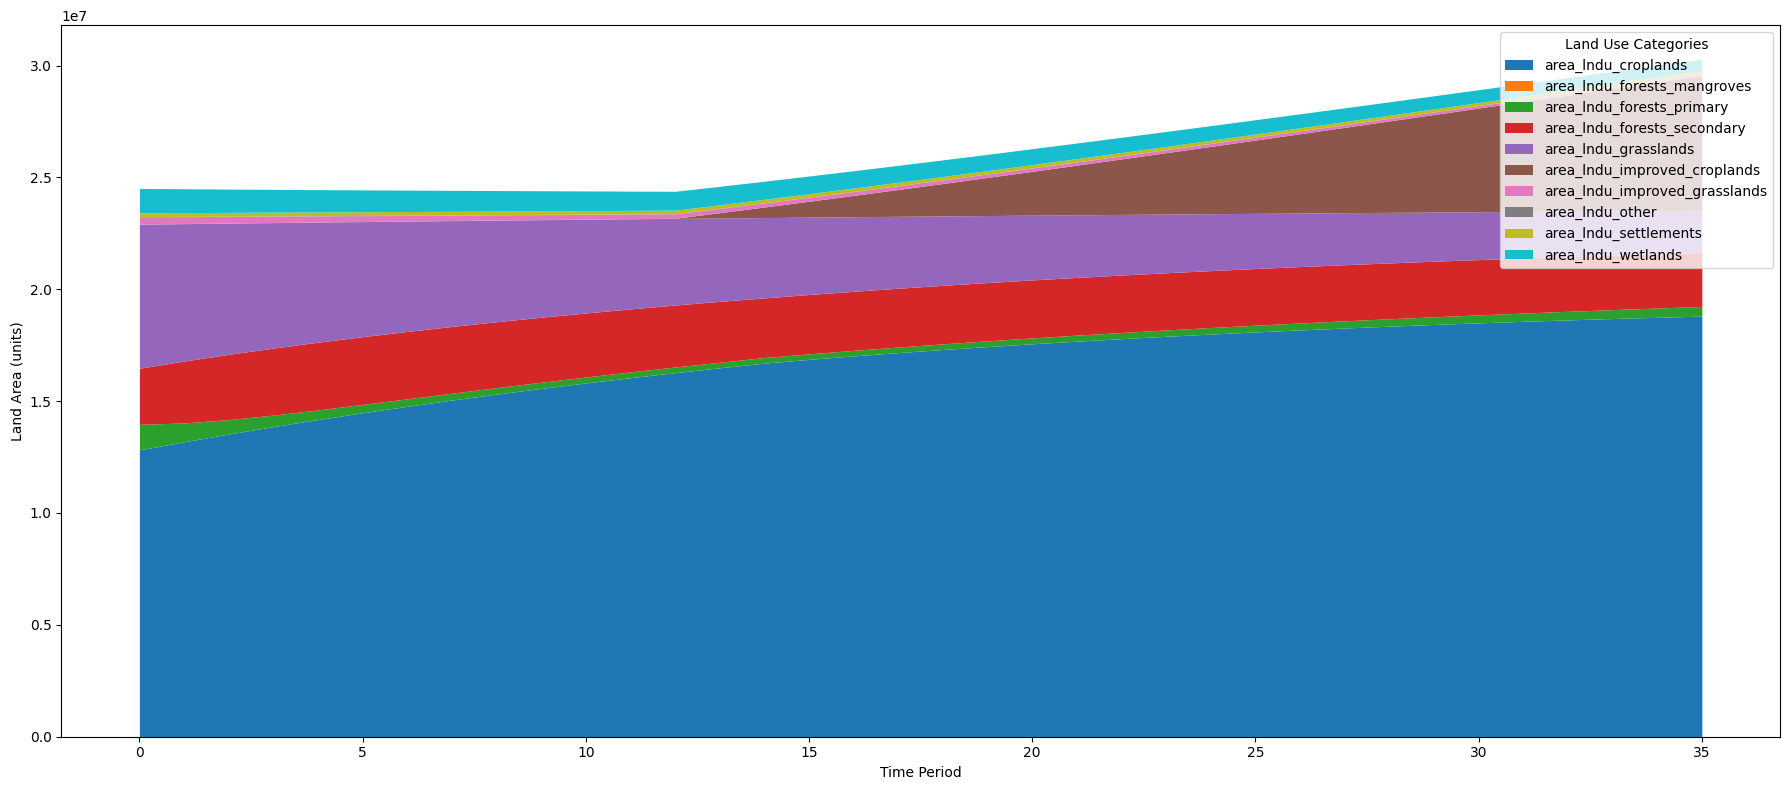

In [155]:
# Filtrar el dataframe
df_plot = df_out[df_out[ssp.key_primary] == 69069]

# Lista de variables a graficar
areas = [
    'area_lndu_croplands',
    'area_lndu_forests_mangroves', 'area_lndu_forests_primary',
    'area_lndu_forests_secondary', 'area_lndu_grasslands',
    'area_lndu_improved_croplands', 'area_lndu_improved_grasslands',
    'area_lndu_other', 'area_lndu_settlements', 'area_lndu_wetlands'
]

# Crear el DataFrame para el área
df_area = df_plot.set_index("time_period")[areas]

# Graficar el área apilada
ax = df_area.plot.area(figsize=(18, 8), linewidth=0)

# Etiquetas y título
ax.set_xlabel("Time Period")
ax.set_ylabel("Land Area (units)")
ax.legend(loc='upper right', title="Land Use Categories")

plt.tight_layout()
plt.show()


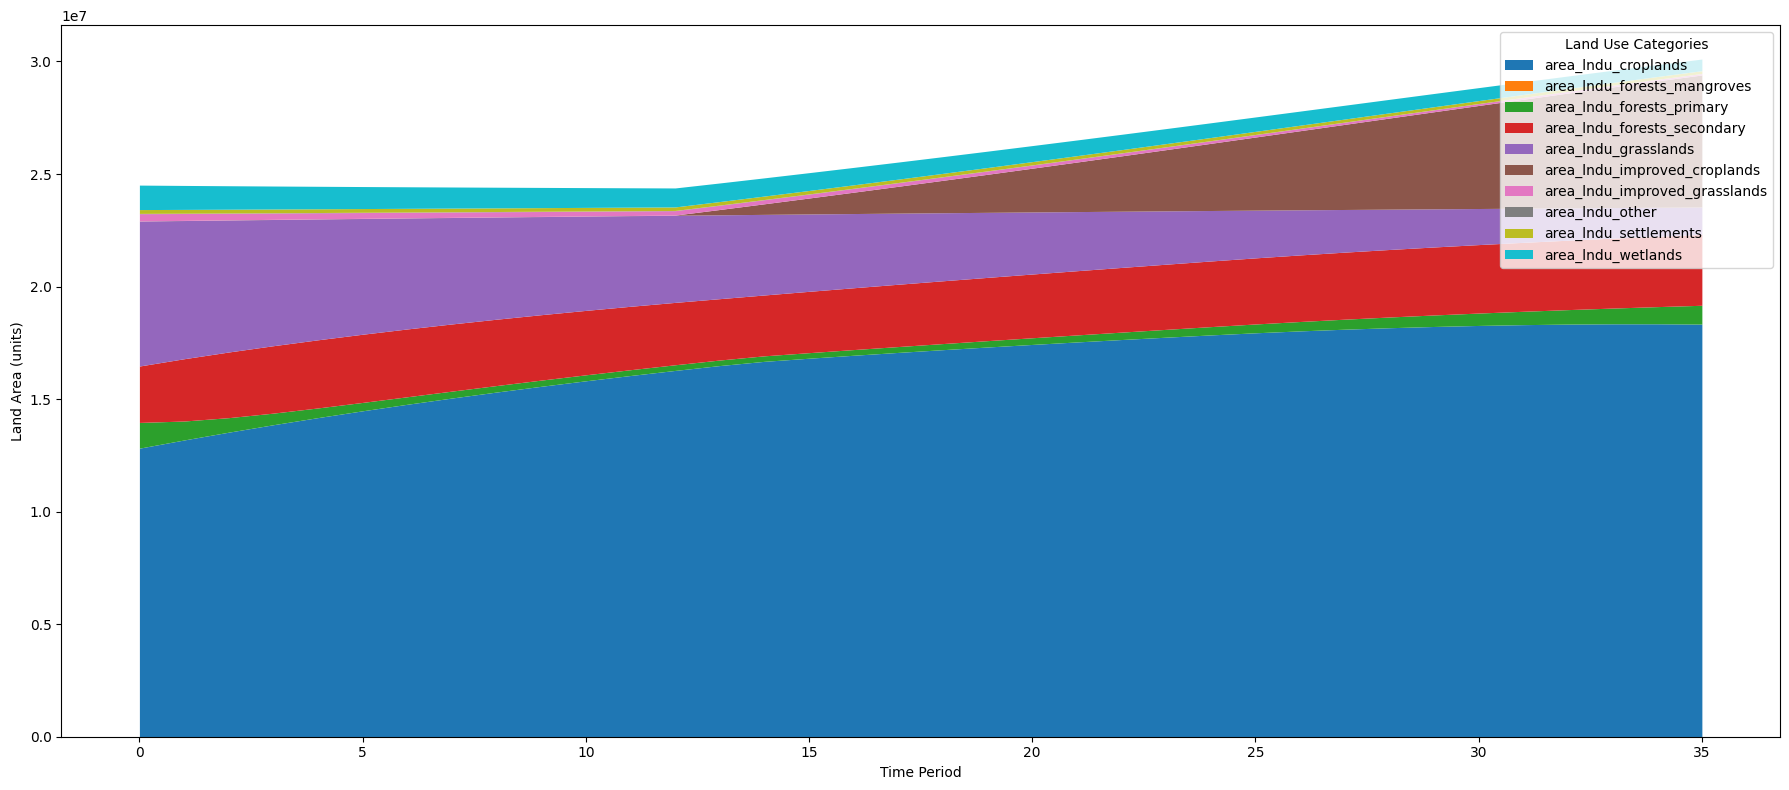

In [156]:
# Filtrar el dataframe
df_plot = df_out[df_out[ssp.key_primary] == 70070]

# Lista de variables a graficar
areas = [
    'area_lndu_croplands',
    'area_lndu_forests_mangroves', 'area_lndu_forests_primary',
    'area_lndu_forests_secondary', 'area_lndu_grasslands',
    'area_lndu_improved_croplands', 'area_lndu_improved_grasslands',
    'area_lndu_other', 'area_lndu_settlements', 'area_lndu_wetlands'
]

# Crear el DataFrame para el área
df_area = df_plot.set_index("time_period")[areas]

# Graficar el área apilada
ax = df_area.plot.area(figsize=(18, 8), linewidth=0)

# Etiquetas y título
ax.set_xlabel("Time Period")
ax.set_ylabel("Land Area (units)")
ax.legend(loc='upper right', title="Land Use Categories")

plt.tight_layout()
plt.show()

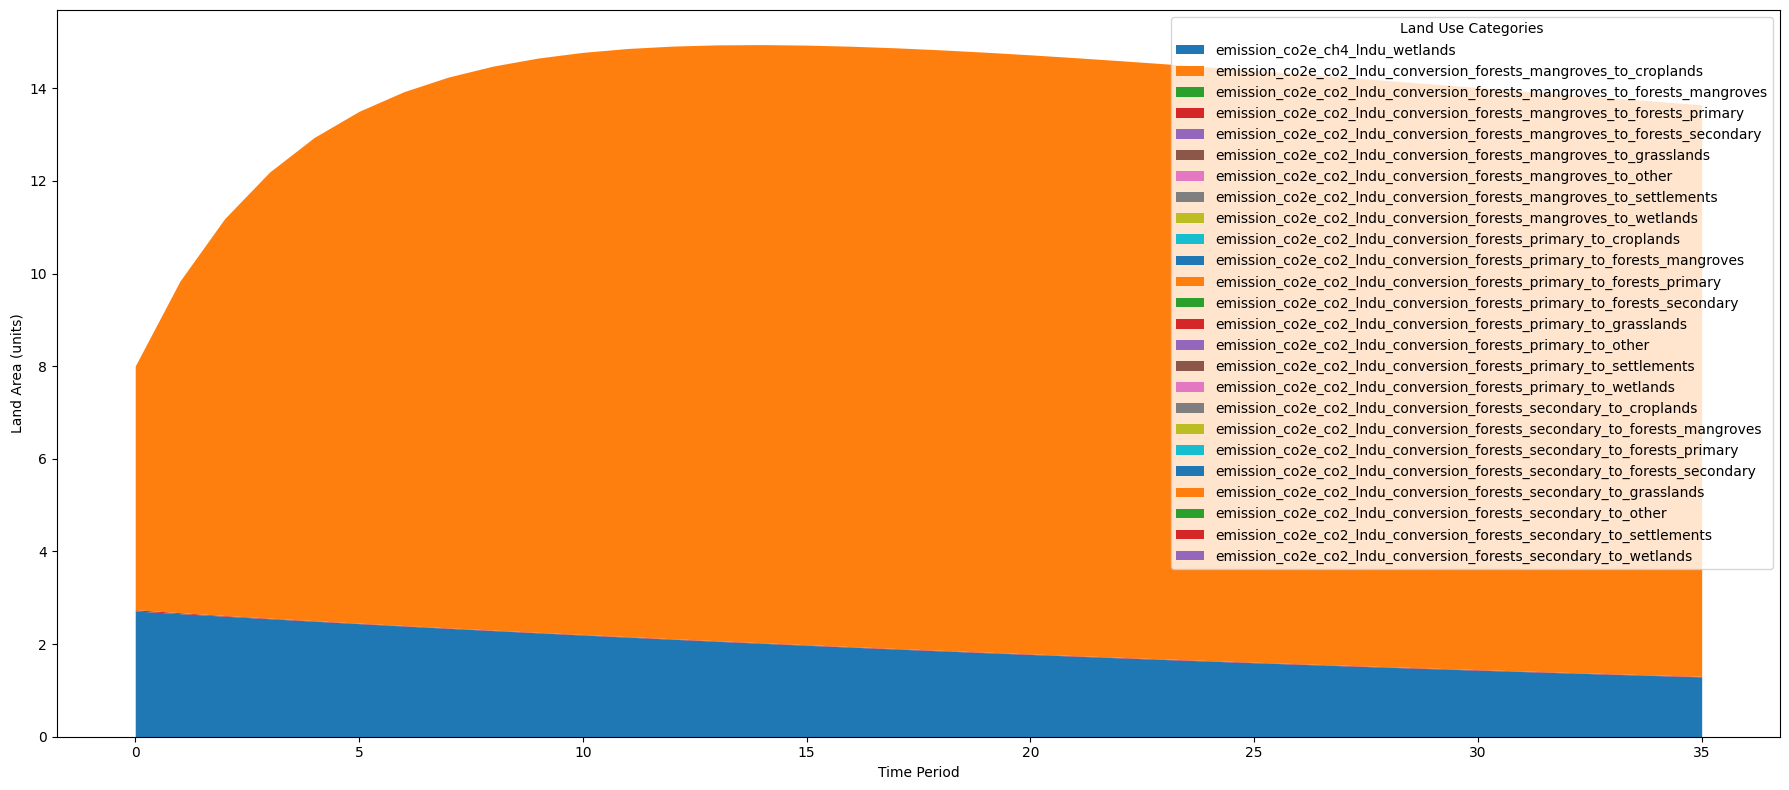

In [157]:
# Filtrar el dataframe
df_plot = df_out[df_out[ssp.key_primary] == 0]

# Lista de variables a graficar
areas= [
    'emission_co2e_ch4_lndu_wetlands',
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_croplands",
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_forests_mangroves",
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_forests_primary",
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_forests_secondary",
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_grasslands",
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_other",
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_settlements",
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_wetlands",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_croplands",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_forests_mangroves",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_forests_primary",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_forests_secondary",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_grasslands",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_other",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_settlements",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_wetlands",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_croplands",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_forests_mangroves",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_forests_primary",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_forests_secondary",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_grasslands",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_other",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_settlements",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_wetlands"
]


# Crear el DataFrame para el área
df_area = df_plot.set_index("time_period")[areas]

# Graficar el área apilada
ax = df_area.plot.area(figsize=(18, 8), linewidth=0)

# Etiquetas y título
ax.set_xlabel("Time Period")
ax.set_ylabel("Land Area (units)")
ax.legend(loc='upper right', title="Land Use Categories")

plt.tight_layout()
plt.show()

# Export Wide File (Last Mandatory Step)

In [158]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)


all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)



# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(dir_pkg, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        print(f"Warning: Table {tab} returned None.")


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [159]:
# Getting the directory where the outputs are stored
ssp.file_struct.dir_out

'/home/fabian_fuentes/anaconda3/envs/ssp_uganda/lib/python3.11/site-packages/sisepuede/out'